# Titanik Top 4% with ensemble modeling

In [86]:
# 2021.08.04

In [2]:
# Content
# 1. Introduction
# 2. Load and check data
# 3. Feature analysis
# 4. Filling missing values
# 5. Feature engineering
# 6. Modeling

## 1. Introduction

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

# 2. Load and check data

### 2.1. Load data

In [4]:
train = pd.read_csv('./Dataset/train.csv')
test = pd.read_csv('./Dataset/test.csv')
IDtest = test['PassengerId']

### 2.2 Outlier detection

In [5]:
def detect_outliers(df, num, features):
    outlier_indices = []
    
    # iterate over features
    for col in features:
        Q1 = np.percentile(df[col], 25) # Return the value of 25% in the df[col]
        Q3 = np.percentile(df[col], 75)
        IQR = Q3-Q1 # IQR = Interquartile range (Range between 25% ~ 75%)
        
        outlier_step = 1.5 * IQR
        # Outlier value positioned outside of 1.5 * IQR range from Q1 and Q3
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        # ********** extend -> [1,2,3].extend([4,5]) -> [1,2,3,4,5] / append -> [1,2,3].append([4,5]) -> [1,2,3,[4,5]] *****
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > num)
    
    # Search all cols, find the row index of outliers and count that. If the count > 2, the row will be droped.
    return outlier_indices, multiple_outliers

outlier_indices, Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch','Fare'])

In [6]:
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [7]:
# Visualize outliers
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [8]:
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

In [9]:
train.shape

(881, 12)

In [10]:
test.shape

(418, 11)

In [11]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [13]:
dataset = pd.concat(objs=[train,test], axis=0).reset_index(drop=True)

In [14]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
dataset.shape

(1299, 12)

In [16]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [17]:
dataset.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## 3. Feature analysis

### 3.1. Numerical values

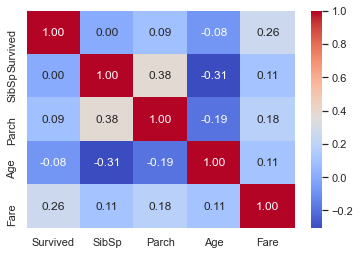

In [18]:
heatmap = sns.heatmap(train[['Survived', 'SibSp', 'Parch','Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

In [19]:
# The result shows the only feature having high correlation with survival is Fare.
# But it doesn't mean the other features are useless

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

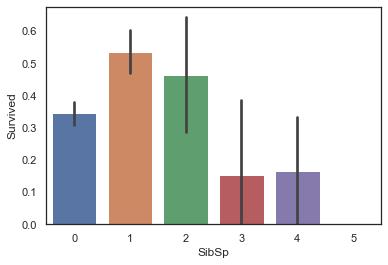

In [20]:
sns.barplot('SibSp','Survived', data=train)

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Parch', ylabel='Survived'>

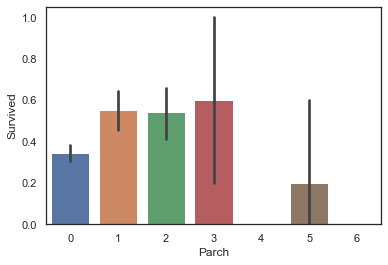

In [21]:
sns.barplot('Parch','Survived', data=train)

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Survived = 1')

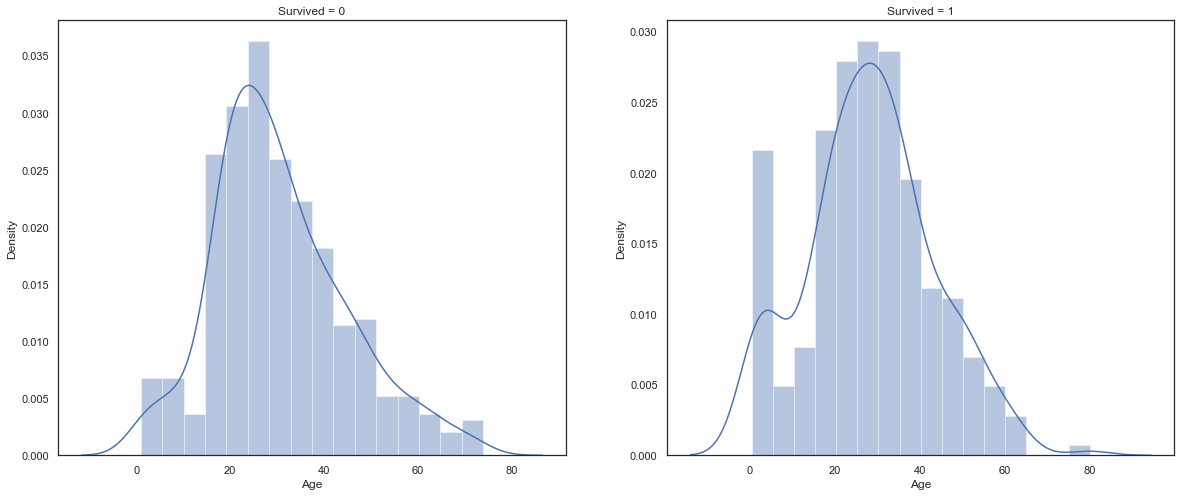

In [22]:
f, ax = plt.subplots(1,2,figsize=(20,8))
sns.distplot(train[train['Survived'] == 0]['Age'], ax=ax[0])
ax[0].set_title('Survived = 0')
sns.distplot(train[train['Survived'] == 1]['Age'], ax=ax[1])
ax[1].set_title('Survived = 1')

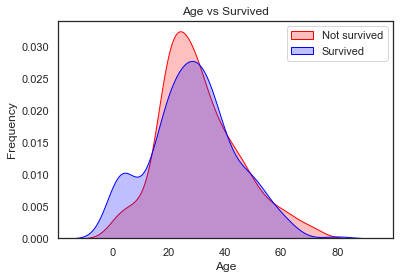

In [23]:
graph1 = sns.kdeplot(train[train['Survived'] == 0]['Age'], color='Red', shade=True)
graph1 = sns.kdeplot(train[train['Survived'] == 1]['Age'], color='blue', shade=True)
graph1.set_title('Age vs Survived')
graph1.set_xlabel('Age')
graph1.set_ylabel('Frequency')
graph1.legend(['Not survived', 'Survived'])

In [24]:
dataset['Fare'].isnull().sum()

1

In [25]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


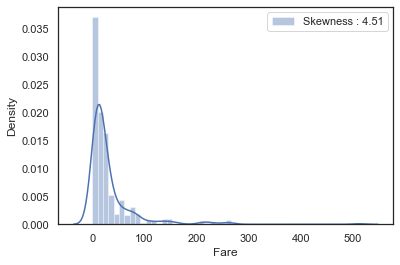

In [26]:
fare_graph = sns.distplot(dataset['Fare'], label='Skewness : %.2f'%(dataset['Fare'].skew()))
fare_graph.legend(loc='best')

In [27]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

## 3.2. Categorical values

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Survival probability')

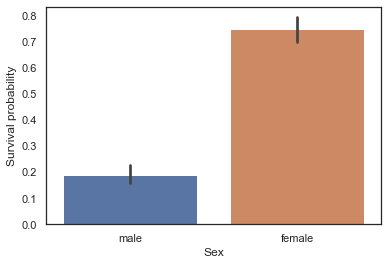

In [28]:
bar_graph1 = sns.barplot('Sex', 'Survived', data=train)
bar_graph1.set_ylabel('Survival probability')

In [29]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Survival probability')

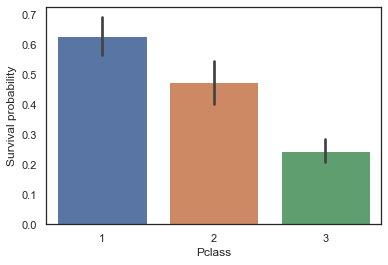

In [30]:
bar_graph2 = sns.barplot('Pclass', 'Survived', data=train)
bar_graph2.set_ylabel('Survival probability')

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


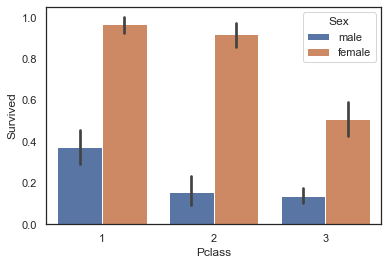

In [31]:
# Pclass vs sex in survival
bar_graph3 = sns.barplot('Pclass', 'Survived', hue='Sex', data=train)

In [32]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1007
Embarked          2
dtype: int64

In [33]:
dataset['Embarked'].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [34]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [35]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1007
Embarked          0
dtype: int64

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Survival probability')

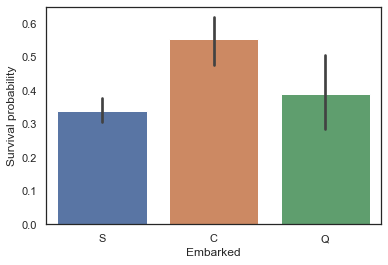

In [36]:
bar_embarked = sns.barplot('Embarked', 'Survived', data=train)
bar_embarked.set_ylabel('Survival probability')

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


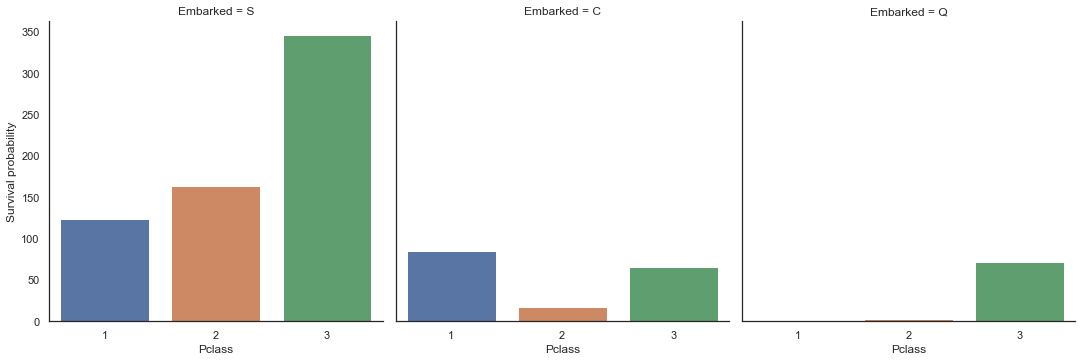

In [37]:
bar_embarked_pclass = sns.factorplot('Pclass', kind='count',data=train, col='Embarked')
bar_embarked_pclass.set_ylabels('Survival probability')

## 4. Filling missing values

### 4.1 Age

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  

<AxesSubplot:xlabel='SibSp', ylabel='Age'>

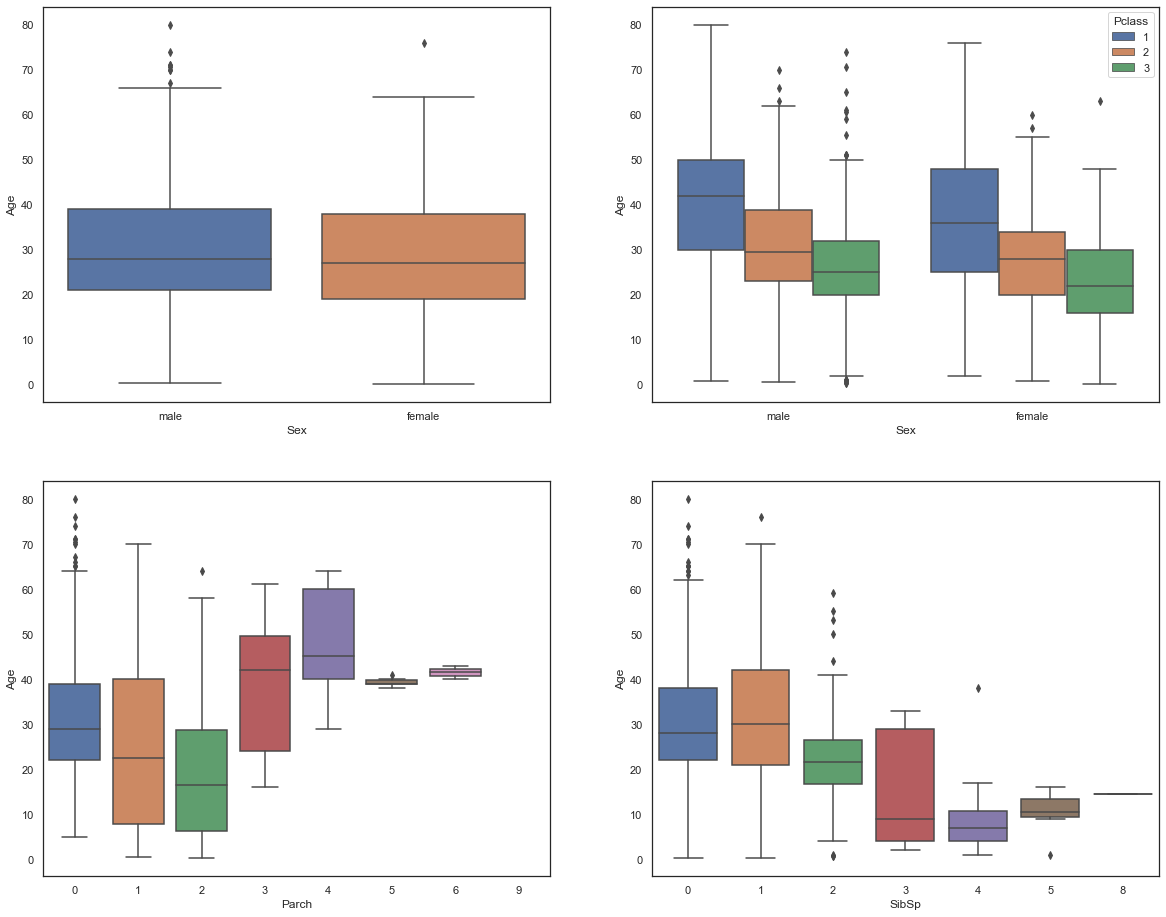

In [38]:
f, ax = plt.subplots(2,2, figsize = (20,16))
sns.boxplot('Sex', 'Age', data=dataset, ax=ax[0,0])
sns.boxplot('Sex', 'Age', hue='Pclass', data=dataset, ax=ax[0,1])
sns.boxplot('Parch', 'Age', data=dataset ,ax=ax[1,0])
sns.boxplot('SibSp', 'Age', data=dataset, ax=ax[1,1])

In [39]:
dataset['Sex'] = dataset['Sex'].map({'male' : 0, 'female' : 1})

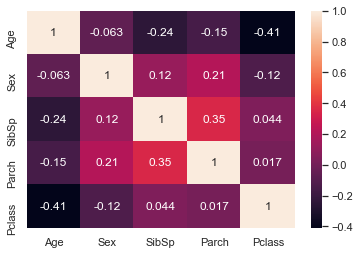

In [40]:
heatmap2 = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), annot=True)

In [41]:
dataset['SibSp'] == dataset.iloc[0]['SibSp']

0        True
1        True
2       False
3        True
4       False
        ...  
1294    False
1295    False
1296    False
1297    False
1298     True
Name: SibSp, Length: 1299, dtype: bool

In [42]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\programdata\anaconda3\envs\jupyter\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\programdata\anaconda3\envs\jupyter\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


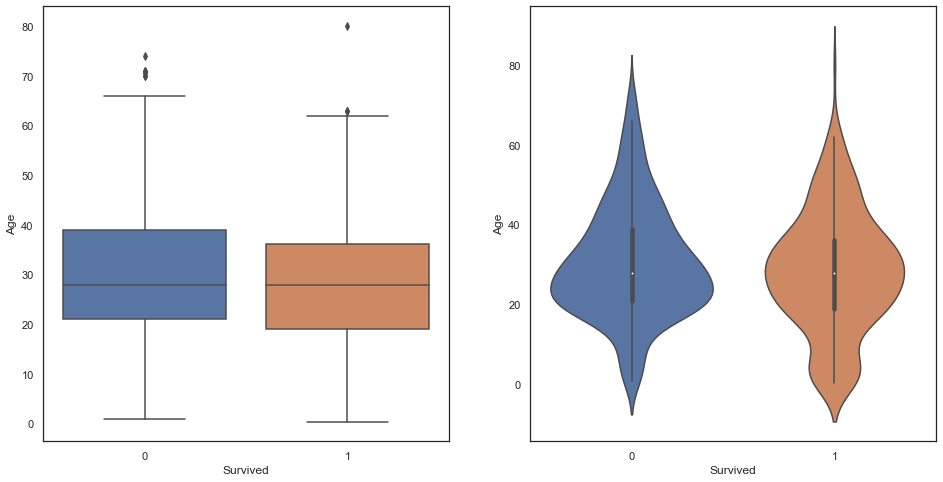

In [43]:
f, ax = plt.subplots(1,2,figsize=(16,8))
box_graph5 = sns.boxplot('Survived', 'Age', data=train, ax=ax[0])
violin_graph1 = sns.violinplot('Survived', 'Age', data=train, ax=ax[1])

# 5. Feature engineering

## 5.1. Name / Title

In [44]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [45]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


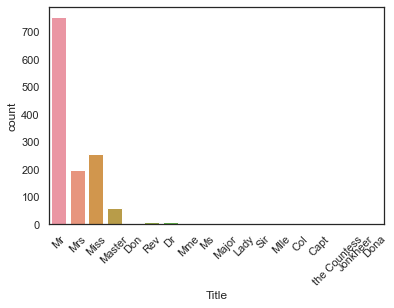

In [46]:
title_countplot = sns.countplot('Title', data=dataset)
title_countplot = plt.setp(title_countplot.get_xticklabels(), rotation=45)

In [47]:
dataset['Title'] = dataset['Title'].replace(['Don', 'Rev', 'the Countess', 'Countess', 'Capt', 'Col', 'Dr', 'Major', 'Sir', 'Jonkheer', 'Dona', 'Lady'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master' : 0, 'Miss' : 1, "Ms" : 1, "Mme" : 1, "Mlle" : 1, "Mrs" : 1, "Mr":2, "Rare" : 3})
dataset['Title'].head()

0    2
1    1
2    1
3    1
4    2
Name: Title, dtype: int64

In [48]:
nulls = dataset[dataset['Title'].isnull()]

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


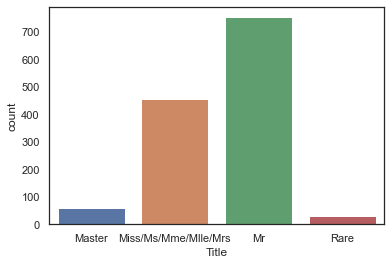

In [49]:
title_countplot = sns.countplot('Title', data=dataset)
title_countplot = title_countplot.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


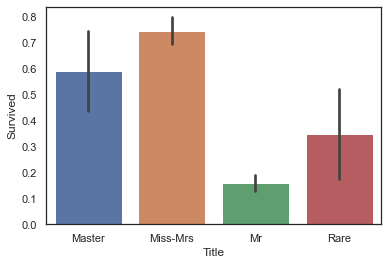

In [50]:
title_survived_countplot = sns.barplot('Title', 'Survived', data=dataset)
title_survived_countplot = title_survived_countplot.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])

In [51]:
dataset.drop(labels=['Name'], axis=1, inplace=True)

In [52]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


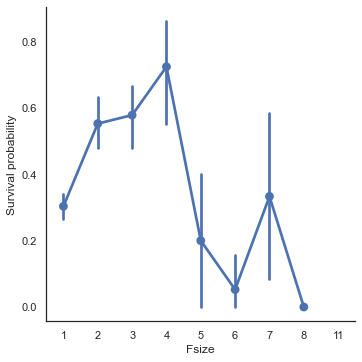

In [53]:
fsize_factorplot = sns.factorplot(x = 'Fsize' , y = 'Survived', data=dataset)
fsize_factorplot = fsize_factorplot.set_ylabels('Survival probability')

In [54]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  

<AxesSubplot:xlabel='Single', ylabel='Survived'>

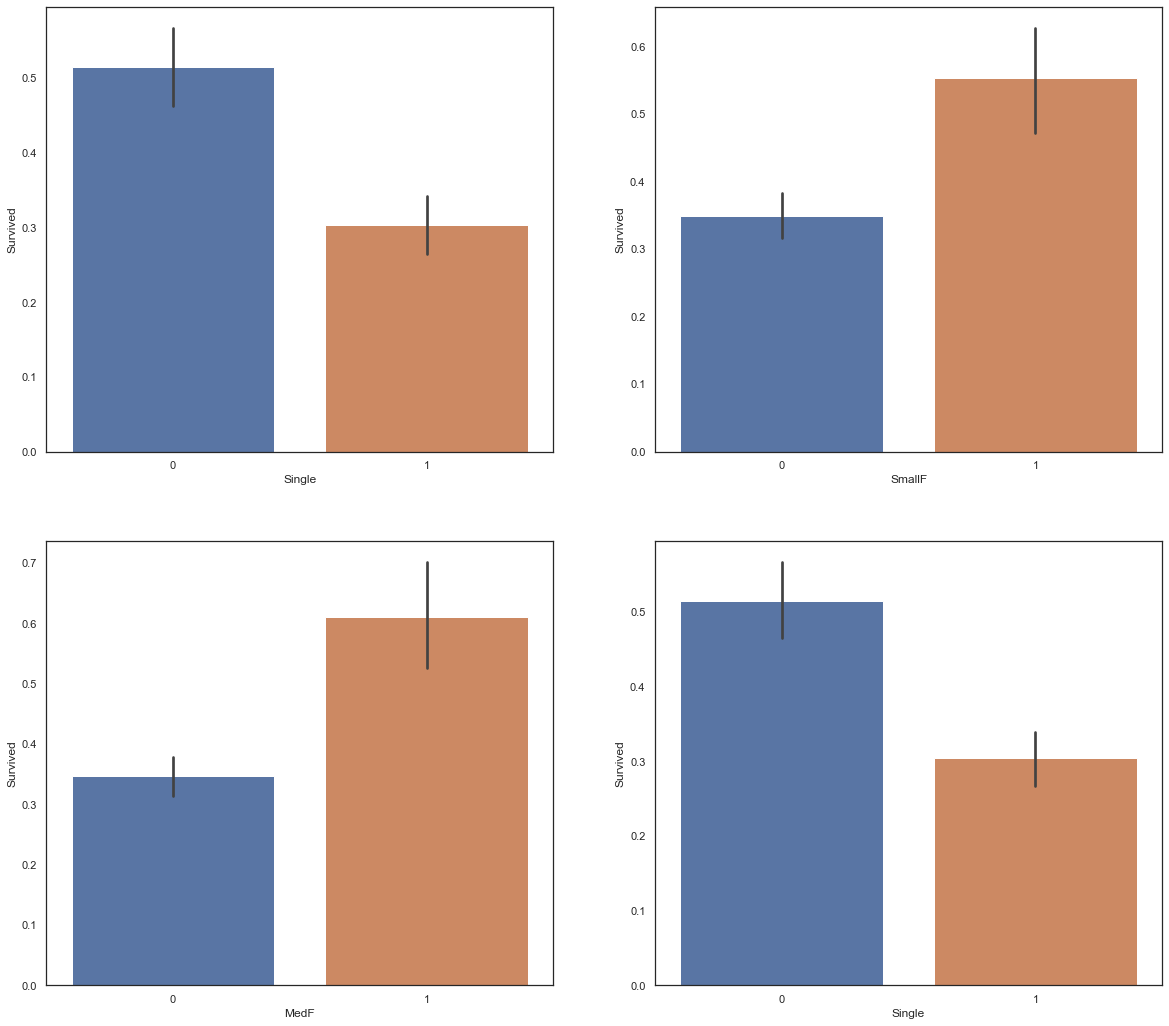

In [55]:
f, ax = plt.subplots(2,2,figsize=(20,18))
sns.barplot('Single', 'Survived', data=dataset, ax=ax[0,0])
sns.barplot('SmallF', 'Survived', data=dataset, ax=ax[0,1])
sns.barplot('MedF', 'Survived', data=dataset, ax=ax[1,0])
sns.barplot('Single', 'Survived', data=dataset, ax=ax[1,1])

In [56]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fsize,Single,SmallF,MedF,LargeF
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,S,2,2,0,1,0,0
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,C,1,2,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,1,1,0,0,0
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,S,1,2,0,1,0,0
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,S,2,1,1,0,0,0


In [57]:
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix='Em')

In [58]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


In [59]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [60]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [61]:
dataset['Cabin'].isnull().sum()

1007

In [62]:
dataset['Cabin'] = pd.Series(i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'])

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Cabin', ylabel='count'>

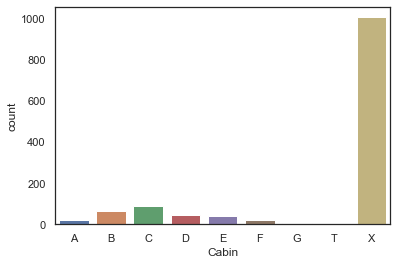

In [63]:
sns.countplot('Cabin', order=['A','B','C','D','E','F','G','T','X'], data=dataset)

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Cabin', ylabel='Survived'>

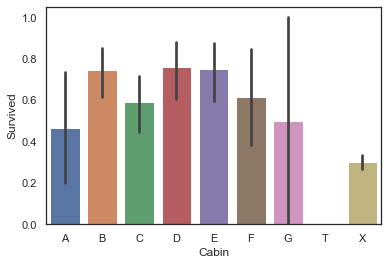

In [64]:
sns.barplot('Cabin', 'Survived', data=dataset, order=['A', 'B','C','D','E','F','G','T','X'])

In [65]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix = 'Cabin')

In [66]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Fsize,...,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,2,...,1,0,0,0,0,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,2,...,0,0,0,1,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,2,...,1,0,0,1,0,0,0,0,0,0
4,5,0.0,3,0,35.0,0,0,373450,2.085672,1,...,1,0,0,0,0,0,0,0,0,1


In [67]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [68]:
# The prefix of ticket can have an information about the Cabin

In [69]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append('X')
        
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [70]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix=['T'])
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fsize,Single,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,1,0.0,3,0,22.0,1,0,1.981001,2,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1.0,1,1,38.0,1,0,4.266662,2,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,2.070022,1,1,...,0,0,0,0,1,0,0,0,0,0
3,4,1.0,1,1,35.0,1,0,3.972177,2,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,2.085672,1,1,...,0,0,0,0,0,0,0,0,0,1


In [71]:
dataset['Pclass'].head()

0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: int64

In [72]:
dataset['pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix='Pc')

# 6. Modeling

In [73]:
train_len = len(train)

In [74]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'],axis=1,inplace=True)

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [75]:
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels=['Survived'], axis = 1)

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## 6.1. Simple modeling

In [76]:
# These models could be compared through the K-Fold cross validation.
# SVC, Decision Tree, AdaBoost, Random Forest, Extra Trees, Gradient Boosting, Multiple layer perceptron, KNN, Logistic regression, Linear Discriminant Analysis

In [77]:
kfold = StratifiedKFold(n_splits=10)

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


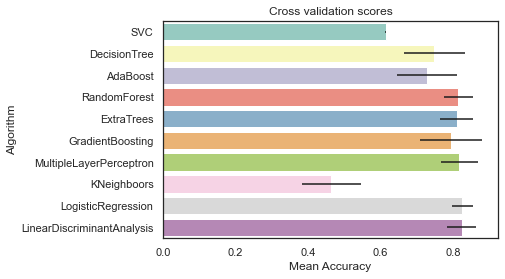

In [78]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state), random_state = random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state = random_state))
classifiers.append(ExtraTreesClassifier(random_state = random_state))
classifiers.append(GradientBoostingClassifier(random_state = random_state))
classifiers.append(MLPClassifier(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring = 'accuracy', cv=kfold, n_jobs=4))
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [79]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state = 7)
ada_param_grid = {"base_estimator__criterion" : ['gini', 'entropy'],
                 'base_estimator__splitter' : ['best', 'random'],
                 "algorithm" : ['SAMME', 'SAMME.R'],
                 "n_estimators" : [1,2],
                 "learning_rate" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv=kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)
gsadaDTC.fit(X_train, Y_train)
ada_best = gsadaDTC.best_estimator_


Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [80]:
gsadaDTC.best_score_

0.7493488253319714

In [81]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8308861082737486

In [82]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8365423901940756

In [83]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8195097037793667

In [84]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.6140704800817159

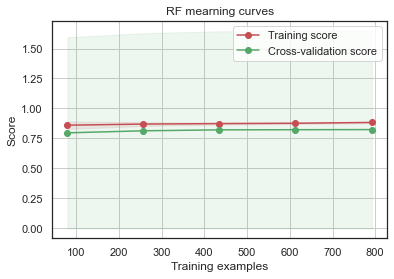

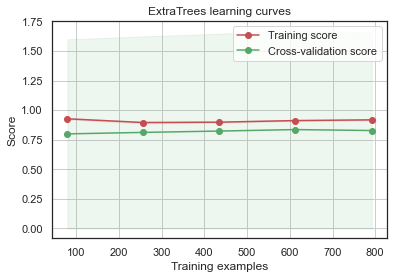

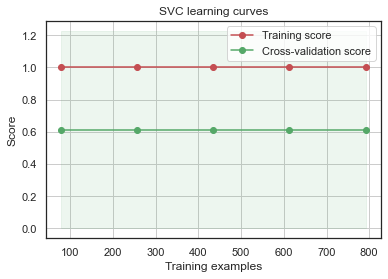

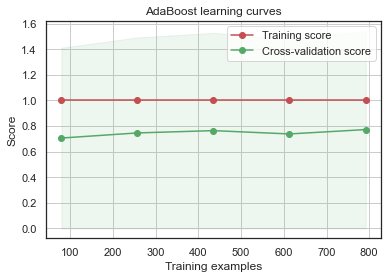

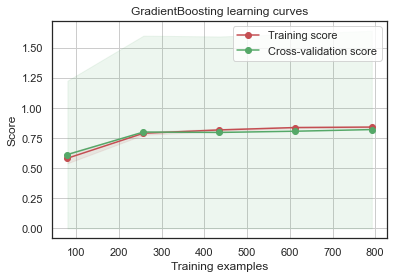

In [85]:
def plot_learning_curve(estimator, title, x, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1,1.0,5)):
    # Generate a simple plot of the test and training learning curve
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores,axis=1)
    test_scores_std = np.mean(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g', label='Cross-validation score')
    plt.legend(loc='best')
    return plt
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\programdata\anaconda3\envs\jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  

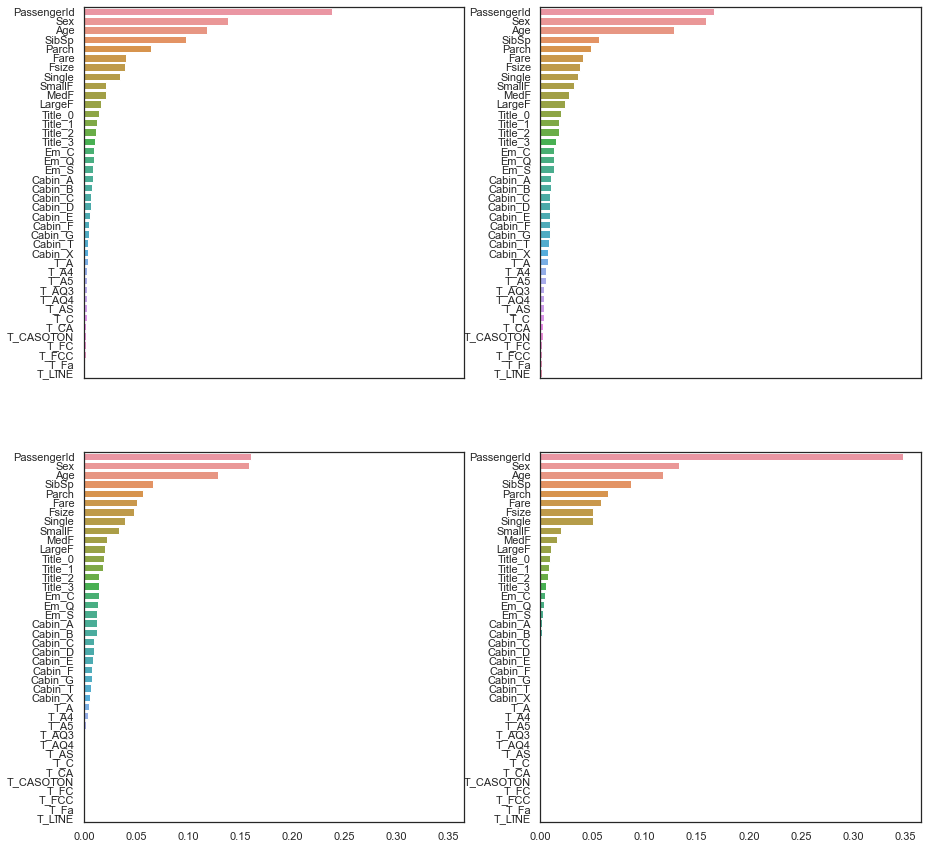

In [89]:
nrows = ncols = 2
fig, ax = plt.subplots(nrows,ncols, sharex='all', figsize=(15,15))

classifiers_name = [('AdaBoosting', ada_best), ("ExtraTrees", ExtC_best), ("RandomForest", RFC_best), ("GradientBoosting", GBC_best)]

num_classifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = classifiers_name[num_classifier][0]
        classifier = classifiers_name[num_classifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        bar5 = sns.barplot(classifier.feature_importances_[indices][:40], X_train.columns[:40], orient='h', ax=ax[row][col])
        num_classifier += 1

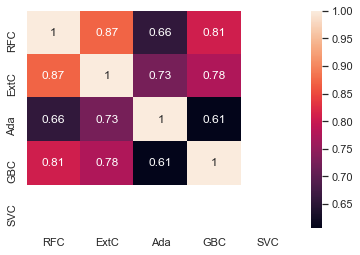

In [90]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name='ExtC')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name='SVC')
test_Survived_AdaC = pd.Series(ada_best.predict(test), name='Ada')
test_Survived_GBC = pd.Series(GBC_best.predict(test), name='GBC')

ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC , test_Survived_GBC, test_Survived_SVMC], axis=1)
g=sns.heatmap(ensemble_results.corr(), annot=True)

In [92]:
votingC =VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac', ada_best), ('gbc', GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train,Y_train)

In [93]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')
results = pd.concat([IDtest, test_Survived], axis=1)
results.to_csv('ensemble_python_voting.csv',index =False)